<a href="https://colab.research.google.com/github/nikitajijo/Webscraping/blob/main/Extracting_Data_From_Annual_Report_Walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing necesary packages

!pip install selenium
!apt-get update -qq
!apt-get install -y chromium-chromedriver
!pip install webdriver_manager
!pip install "camelot-py[cv]"
!pip install PyPDF2==1.26.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.6/461.6 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor chromium-browser libfuse3-3 liblzo2-2 libudev1 snapd squashfs-tools systemd-hwe-hwdb
  udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser chromium-chromedriver libfuse3-3 liblzo2-2 snapd squashfs-tools
  systemd-hwe-hwdb udev
The following packages will be upgraded:
  libudev1
1 upgraded, 9 newly installed, 0 to remove and 23 not upgraded.
Need to get 26.4 MB of archives.
After this operation, 116 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu j

In [ ]:
# Import necessary modules

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select, WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
import os
import pandas as pd
import camelot
import re

In [ ]:
options = webdriver.ChromeOptions()

# Set download directory
download_directory = "/content/Annual_Reports1"
prefs = {
    "download.default_directory": download_directory,
    "download.prompt_for_download": False,
    "plugins.always_open_pdf_externally": True
}

options.add_experimental_option("prefs", prefs)
options.add_argument("--headless")
options.add_argument("--no-sandbox")

# Setting the path to the Chrome executable
options.binary_location = '/usr/bin/google-chrome'

# Create a Chrome webdriver instance
driver = webdriver.Chrome(options=options)
URL = "https://stock.walmart.com/financials/annual-reports/default.aspx"
driver.get(URL)
driver.implicitly_wait(3)

# Create a file to store PDF paths
output_file_path = "/content/pdf_paths.txt"

# Find the annual report link for 2023 and include its path
annual_report_2023_link = driver.find_element(By.XPATH, "//span[contains(text(), '2023 Annual Report PDF')]")
annual_report_2023_link.click()  # Trigger the download
time.sleep(5)  # Wait for the download to complete
downloaded_file_path_2023 = download_directory + "/2023 Annual Report PDF.pdf"
with open(output_file_path, 'a') as file:
    file.write(downloaded_file_path_2023 + '\n')

# Find the dropdown element
year_dropdown = Select(driver.find_element(By.ID, 'financialArchiveYear'))

# Get all available options (years) from the dropdown
available_years = [option.text for option in year_dropdown.options]

# Loop through the available years (except 2023) and download reports
for target_year in available_years:
    # Convert the target year to an integer for comparison
    target_year_int = int(target_year)

    # Download only if the year is from 2022 to 2002
    if 2022 >= target_year_int >= 2002:
        # Select the year from the dropdown
        year_dropdown.select_by_visible_text(target_year)

        # Wait for the download link to be clickable
        wait = WebDriverWait(driver, 10)

        # Try finding the PDF with the year in the name
        annual_report_link = None
        try:
            annual_report_link = wait.until(EC.element_to_be_clickable((By.XPATH, f"//span[contains(text(), '{target_year}')]")))
        except:
            pass

        # If a link is found, trigger the download for the selected year
        if annual_report_link is not None:
            annual_report_link.click()
            time.sleep(5)  # Wait for the download to complete


# Close the browser window once all downloads are complete.
driver.quit()


In [ ]:
# Ensuring that paths are being written in the order of their modification time.
# Directory where the PDF files are located
pdf_directory = "/content/Annual_Reports1/"

# Get a list of PDF files in the directory and sort them by modification time
pdf_files = sorted([file for file in os.listdir(pdf_directory) if file.lower().endswith(".pdf")],
                   key=lambda f: os.path.getmtime(os.path.join(pdf_directory, f)))

# Generate correct paths and write them to pdf_paths.txt
with open("/content/pdf_paths.txt", "w") as file:
    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_directory, pdf_file)
        file.write(pdf_path + "\n")

print("PDF paths have been written to pdf_paths.txt.")

PDF paths have been written to pdf_paths.txt.


In [ ]:
# Function to extract tables based on a keyword
# Here the keyword used is "Revenues"
# This function will be saving the table as row wise

def extract_table_from_pdf(pdf_path, keyword):
    try:
        # Read tables from the PDF
        tables = camelot.read_pdf(pdf_path, flavor="stream", pages="all", strip_text=' $')

        # Iterate through each table and look for the keyword
        for i, table in enumerate(tables):
            # Combine all text in the table into a single string
            table_text = " ".join(" ".join(row) for row in table.data)

            # Check if the keyword is present in the table text
            if re.search(re.escape(keyword), table_text):
                # Extract the year from the PDF file name
                match = re.search(r'(\d{4})', os.path.basename(pdf_path))
                pdf_year = match.group(1) if match else "Unknown"

                # Save the table to an Excel file with the year in the file name
                output_folder = "output_tables"
                os.makedirs(output_folder, exist_ok=True)
                output_file = os.path.join(output_folder, f"{re.sub('[^a-zA-Z0-9]', '', keyword.lower())}_{pdf_year}_page_{table.page}.xlsx")
                table.df.to_excel(output_file, index=False)
                print(f"Table saved to {output_file}")

                return table.df  # Return the DataFrame for later concatenation

        return None  # Return None if the keyword is not found

    except Exception as e:
        print(f"Error processing {pdf_path}: {str(e)}")
        return None

# Path to the file containing PDF paths
pdf_paths_file = "/content/pdf_paths.txt"

# Keyword to search for in the tables
keyword = "Revenues:"

# Read PDF paths from the file
with open(pdf_paths_file, "r") as file:
    pdf_paths = file.readlines()

# List to store DataFrames for later concatenation
dfs = []

# Iterate through each PDF path and extract tables
for pdf_path in pdf_paths:
    pdf_path = pdf_path.strip()  # Remove leading/trailing whitespaces
    df = extract_table_from_pdf(pdf_path, keyword)
    if df is not None:
        dfs.append(df)

# Concatenate DataFrames and save to a single Excel file outside the output folder
if dfs:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.to_excel("concatenated_tables.xlsx", index=False)
    print("Concatenated tables saved to concatenated_tables.xlsx")


Table saved to output_tables/revenues_Unknown_page_56.xlsx


Table saved to output_tables/revenues_2022_page_55.xlsx


Table saved to output_tables/revenues_2020_page_52.xlsx


Table saved to output_tables/revenues_2019_page_56.xlsx


Table saved to output_tables/revenues_2018_page_61.xlsx


Table saved to output_tables/revenues_2017_page_38.xlsx


Table saved to output_tables/revenues_2016_page_37.xlsx


Table saved to output_tables/revenues_2015_page_38.xlsx


Table saved to output_tables/revenues_2014_page_38.xlsx


Table saved to output_tables/revenues_2013_page_34.xlsx


Table saved to output_tables/revenues_2012_page_34.xlsx


Table saved to output_tables/revenues_2011_page_32.xlsx


Table saved to output_tables/revenues_2010_page_32.xlsx


Table saved to output_tables/revenues_2009_page_32.xlsx


Table saved to output_tables/revenues_2007_page_41.xlsx


Table saved to output_tables/revenues_2006_page_32.xlsx
Error processing /content/Annual_Reports1/2005-annual-report-for-walmart-stores-inc_130202966828901734.pdf: unpack requires a buffer of 12 bytes


Table saved to output_tables/revenues_2004_page_35.xlsx


Table saved to output_tables/revenues_2003_page_32.xlsx


Concatenated tables saved to concatenated_tables.xlsx


In [ ]:
# This will be saving the tables column wise

# Function to extract tables based on a keyword
def extract_table_from_pdf(pdf_path, keyword):
    try:
        # Read tables from the PDF
        tables = camelot.read_pdf(pdf_path, flavor="stream", pages="all", strip_text=' $')

        # Iterate through each table and look for the keyword
        for i, table in enumerate(tables):
            # Combine all text in the table into a single string
            table_text = " ".join(" ".join(row) for row in table.data)

            # Check if the keyword is present in the table text
            if re.search(re.escape(keyword), table_text):
                return table.df  # Return the DataFrame for later concatenation

        return None  # Return None if the keyword is not found

    except Exception as e:
        print(f"Error processing {pdf_path}: {str(e)}")
        return None

# Path to the file containing PDF paths
pdf_paths_file = "/content/pdf_paths.txt"

# Keyword to search for in the tables
keyword = "Revenues:"

# Read PDF paths from the file
with open(pdf_paths_file, "r") as file:
    pdf_paths = file.readlines()

# List to store DataFrames for later concatenation
dfs = []

# Iterate through each PDF path and extract tables
for pdf_path in pdf_paths:
    pdf_path = pdf_path.strip()  # Remove leading/trailing whitespaces
    df = extract_table_from_pdf(pdf_path, keyword)
    if df is not None:
        dfs.append(df)

# Concatenate DataFrames
if dfs:
    concatenated_df = pd.concat(dfs, axis=1)  # Concatenate along columns
    concatenated_df.to_excel("concatenated_tables1.xlsx", index=False)
    print("Concatenated tables saved to concatenated_tables1.xlsx")


Error processing /content/Annual_Reports1/2005-annual-report-for-walmart-stores-inc_130202966828901734.pdf: unpack requires a buffer of 12 bytes


Concatenated tables saved to concatenated_tables1.xlsx


In [ ]:
# Doing the preprocessing
# Deletinng the first two rows and making the 3 rd row as the column title
# Deleting the blank column

# Path to the input Excel file
input_excel_path = "/content/concatenated_tables1.xlsx"

# Read the Excel file, skipping the first two rows
original_df = pd.read_excel(input_excel_path, skiprows=2, header=None)
# Remove blank columns
original_df = original_df.dropna(axis=1, how="all")

# Use the first row as column names and save to a new Excel file
original_df.columns = original_df.iloc[0]
original_df = original_df[1:]

# Save the modified DataFrame to a new Excel file without adding decimals
output_excel_path = "modified_data3.xlsx"
original_df.to_excel(output_excel_path, index=False)

print(f"Modified data saved to {output_excel_path}")


Modified data saved to modified_data3.xlsx


In [ ]:
excel_file_path = '/content/modified_data3.xlsx'

# Read Excel file into a DataFrame
df = pd.read_excel(excel_file_path)

# Display the DataFrame
df

,"(Amountsinmillions,exceptpersharedata)",2023,2022,2021,"(Amountsinmillions,exceptpersharedata).1",2022.1,2021.1,2020,"(Amountsinmillions,exceptpersharedata).2",2020.1,...,Unnamed: 62,Unnamed: 63,(Amountsinmillionsexceptpersharedata).3,Unnamed: 65,Unnamed: 66,Unnamed: 67,(Amountsinmillionsexceptpersharedata).4,Unnamed: 69,Unnamed: 70,Unnamed: 71
0,Revenues:,NaN,NaN,NaN,Revenues:,NaN,NaN,NaN,Revenues:,NaN,...,NaN,NaN,"FiscalyearsendedJanuary31,",2004,2003,2002,"FiscalyearsendedJanuary31,",2003,2002,2001
1,Netsales,"605,881","567,762","555,233",Netsales,"567,762","555,233","519,926",Netsales,"519,926",...,2005,2004,Revenues:,NaN,NaN,NaN,Revenues:,NaN,NaN,NaN
2,Membershipandotherincome,"5,408","4,992","3,918",Membershipandotherincome,"4,992","3,918","4,038",Membershipandotherincome,"4,038",...,NaN,NaN,Netsales,"256,329","229,616","204,011",Netsales,"244,524","217,799","191,329"
3,Totalrevenues,"611,289","572,754","559,151",Totalrevenues,"572,754","559,151","523,964",Totalrevenues,"523,964",...,"285,222","256,329","Otherincome,net","2,352","1,961","1,812",Otherincome,"2,001","1,873","1,787"
4,Costsandexpenses:,NaN,NaN,NaN,Costsandexpenses:,NaN,NaN,NaN,Costsandexpenses:,NaN,...,"2,910","2,352",NaN,"258,681","231,577","205,823",NaN,"246,525","219,672","193,116"
5,Costofsales,"463,721","429,000","420,315",Costofsales,"429,000","420,315","394,605",Costofsales,"394,605",...,"288,132","258,681",CostsandExpenses:,NaN,NaN,NaN,CostsandExpenses:,NaN,NaN,NaN
6,"Operating,selling,generalandadministrativeexpe...","127,140","117,812","116,288","Operating,selling,generalandadministrativeexpe...","117,812","116,288","108,791","Operating,selling,generalandadministrativeexpe...","108,791",...,NaN,NaN,Costofsales,"198,747","178,299","159,097",Costofsales,"191,838","171,562","150,255"
7,Operatingincome,"20,428","25,942","22,548",Operatingincome,"25,942","22,548","20,568",Operatingincome,"20,568",...,"219,793","198,747","Operating,selling,generalandadministrativeexpe...","44,909","39,983","35,147","Operating,sellingandgeneralandadministrativeex...","41,043","36,173","31,550"
8,Interest:,NaN,NaN,NaN,Interest:,NaN,NaN,NaN,Interest:,NaN,...,"51,248","44,909",OperatingProfit,"15,025","13,295","11,579",OperatingProfit,"13,644","11,937","11,311"
9,Debt,"1,787","1,674","1,976",Debt,"1,674","1,976","2,262",Debt,"2,262",...,"17,091","15,025",Interest:,NaN,NaN,NaN,Interest:,NaN,NaN,NaN


In [ ]:
df_rows = pd.DataFrame(df.head())
# Transpose the DataFrame to switch rows and columns
df_transposed = df_rows.T

# Drop duplicate columns based on values
df_transposed_dedup = df_transposed.drop_duplicates()

# Transpose the result back to the original orientation
df_dedup = df_transposed_dedup.T

# Display the DataFrame without duplicate columns based on values
df_dedup

,"(Amountsinmillions,exceptpersharedata)",2023,2022,2021,2020,2019,2018,2017,2016,2015,...,Unnamed: 62,Unnamed: 63,(Amountsinmillionsexceptpersharedata).3,Unnamed: 65,Unnamed: 66,Unnamed: 67,(Amountsinmillionsexceptpersharedata).4,Unnamed: 69,Unnamed: 70,Unnamed: 71
0,Revenues:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"FiscalyearsendedJanuary31,",2004,2003,2002,"FiscalyearsendedJanuary31,",2003,2002,2001
1,Netsales,"605,881","567,762","555,233","519,926","510,329","495,761","481,317","478,614","482,229",...,2005,2004,Revenues:,NaN,NaN,NaN,Revenues:,NaN,NaN,NaN
2,Membershipandotherincome,"5,408","4,992","3,918","4,038","4,076","4,582","4,556","3,516","3,422",...,NaN,NaN,Netsales,"256,329","229,616","204,011",Netsales,"244,524","217,799","191,329"
3,Totalrevenues,"611,289","572,754","559,151","523,964","514,405","500,343","485,873","482,130","485,651",...,"285,222","256,329","Otherincome,net","2,352","1,961","1,812",Otherincome,"2,001","1,873","1,787"
4,Costsandexpenses:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"2,910","2,352",NaN,"258,681","231,577","205,823",NaN,"246,525","219,672","193,116"


In [ ]:
new_df1 = df_dedup.iloc[:, :13]
new_df1

,"(Amountsinmillions,exceptpersharedata)",2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012
0,Revenues:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Netsales,"605,881","567,762","555,233","519,926","510,329","495,761","481,317","478,614","482,229","473,076","465,604","443,416"
2,Membershipandotherincome,"5,408","4,992","3,918","4,038","4,076","4,582","4,556","3,516","3,422","3,218","3,047","3,093"
3,Totalrevenues,"611,289","572,754","559,151","523,964","514,405","500,343","485,873","482,130","485,651","476,294","468,651","446,509"
4,Costsandexpenses:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


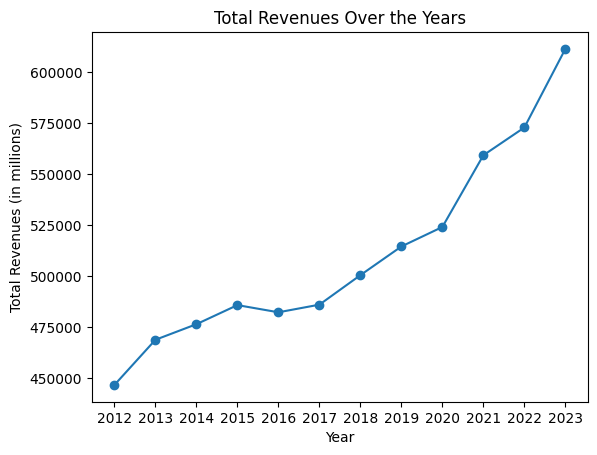

In [ ]:
import matplotlib.pyplot as plt

# Transpose the DataFrame to have years as index
df_transposed = new_df1.set_index("(Amountsinmillions,exceptpersharedata)").T

# Extract the Totalrevenues row
total_revenues = df_transposed["Totalrevenues"]

# Convert the data to numeric (removing commas and converting to float)
total_revenues = total_revenues.replace({',': ''}, regex=True).astype(float)

# Plotting the line chart
plt.plot(total_revenues.index, total_revenues.values, marker='o', linestyle='-')

# Invert the x-axis to display years from oldest to latest
plt.gca().invert_xaxis()

# Adding labels and title
plt.xlabel("Year")
plt.ylabel("Total Revenues (in millions)")
plt.title("Total Revenues Over the Years")

# Display the plot
plt.show()
